In [1]:
import torch
import cv2
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from torch.optim import Adam
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class VQVAE(nn.Module):
    def __init__(self,image_channel=1,h_dim=16,l_dim=4, num_embeddings=3,embedding_dim=2):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channel, h_dim, 4, stride=2, padding=1),
            nn.BatchNorm2d(h_dim),
            nn.ReLU(),
            nn.Conv2d(h_dim, l_dim, 4, stride=2, padding=1),
            nn.BatchNorm2d(l_dim),
            nn.ReLU(),
        )

        self.pre_quant_conv = nn.Conv2d(l_dim, embedding_dim, kernel_size=1)
        self.embedding = nn.Embedding(num_embeddings=num_embeddings,
                                      embedding_dim=embedding_dim)
        self.post_quant_conv = nn.Conv2d(embedding_dim, l_dim, kernel_size=1)

        # Commitment Loss Beta
        self.beta = 0.2

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(l_dim, h_dim, 4, stride=2, padding=1),
            nn.BatchNorm2d(h_dim),
            nn.ReLU(),
            nn.ConvTranspose2d(h_dim, image_channel, 4, stride=2, padding=1),
            nn.Tanh(),
        )


    def forward(self, x):
        # encoding and preparing to quantize
        encoded_output = self.encoder(x)
        quant_input = self.pre_quant_conv(encoded_output)

        # Quantization
        B, C, H, W = quant_input.shape
        # reshape x -> (batch, height, width, channel)
        quant_input = quant_input.permute(0, 2, 3, 1)
        quant_input = quant_input.reshape((quant_input.size(0), -1, quant_input.size(-1)))

        # calculating the distance between each z and embeding in a pairwise way
        # repeat function for permutation
        # print( self.embedding.weight.shape)
        distance = torch.cdist(quant_input, self.embedding.weight[None, :].repeat((quant_input.size(0), 1, 1)))
        # print(dist.shape)

        # finding index of nearest embedding
        min_encoding_indices = torch.argmin(distance, dim=-1)

        # Select the embedding weights
        quant_out = torch.index_select(self.embedding.weight, 0, min_encoding_indices.view(-1))
        quant_input = quant_input.reshape((-1, quant_input.size(-1)))
        codebook_outputs = quant_out
        # codebook_outputs.shape
        # Compute losses
        commitment_loss = torch.mean((quant_out.detach() - quant_input)**2)
        codebook_loss = torch.mean((quant_out - quant_input.detach())**2)
        quantize_losses = codebook_loss + self.beta*commitment_loss

        # Ensure straight through gradient
        quant_out = quant_input + (quant_out - quant_input).detach()

        # Reshaping back to original input shape
        quant_out = quant_out.reshape((B, H, W, C)).permute(0, 3, 1, 2)
        min_encoding_indices = min_encoding_indices.reshape((-1, quant_out.size(-2), quant_out.size(-1)))


        ## Decoder part
        decoder_input = self.post_quant_conv(quant_out)
        output = self.decoder(decoder_input)
        return output, quantize_losses, self.embedding.weight, codebook_outputs




In [ ]:
def train_vqvae():
    transform = transforms.Compose([transforms.ToTensor()])
    mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    mnist_test = datasets.MNIST(root='./data', train=False, transform=transform)
    mnist_loader = DataLoader(mnist, batch_size=64, shuffle=True, num_workers=4)

    model = VQVAE().to(device)

    num_epochs = 10
    optimizer = Adam(model.parameters(), lr=1E-3)
    criterion = torch.nn.MSELoss()
    codebook_outputs = []
    embeddings = []
    losses = []
    for epoch_idx in range(num_epochs):
        loss = 0
        num_data=0
        for i, (im, label) in enumerate(tqdm(mnist_loader)):
            im = im.float().to(device)
            optimizer.zero_grad()
            out, quantize_loss, embedding, codebook = model(im)

            recon_loss = criterion(out, im)
            loss = recon_loss + quantize_loss
            loss.backward()
            optimizer.step()

            loss += loss.item()
            num_data=len(label)
            if(i%60==0):
              embeddings.append(embedding.detach())
              codebook_outputs.append(codebook)
        losses.append(loss/num_data)

        print('Finished epoch {}'.format(epoch_idx+1))
    print('Done Training...')

    # Reconstruction part

    idxs = torch.randint(0, len(mnist_test), (20, ))
    random_test_batch = []
    for idx in idxs:
      img, _ = mnist_test[idx]
      img = img.reshape(1,28,28)
      random_test_batch.append(img)
    random_test_batch = torch.stack(random_test_batch)
    random_test_batch = random_test_batch.to(device)
    model.eval()

    with torch.no_grad():
      recon, _,embedding,codebook_test = model(random_test_batch)

      out = torch.concat([random_test_batch, recon],dim=3)

      out1 = out[0]
      out2 = out[10]

      for i in range(1,10):
        out1 = torch.concat([out1, out[i]],dim=2)
        out2 = torch.concat([out2, out[10+i]],dim=2)
      img = torch.concat([out1, out2],dim=1)

      plt.imshow(img.permute(1,2,0).cpu())
      plt.show()


      # plotting the embedding of each test data
      # defining colors for each class
      colors = ['red', 'green', 'blue']
      # scatter plot with different colors
      print(codebook_test)
      for i in range(1,20+1):
        plt.subplot(2,10,i)
        embed = embedding.cpu()
        codebook_test = codebook_test.cpu()
        plt.scatter(embed[0, 0], embed[0, 1], c=colors[0], s=25)
        plt.scatter(embed[1, 0], embed[1, 1], c=colors[1], s=25)
        plt.scatter(embed[2, 0], embed[2, 1], c=colors[2], s=25)
        plt.scatter(codebook_test[:, 0], codebook_test[:, 1], c='gray', s=5)
      plt.show()
      img = torch.concat([out1, out2],dim=1)

    return model, losses, embeddings,codebook_outputs




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████

Finished epoch 1


  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 938/938 [00:37<00:00, 24.86it/s]


Finished epoch 2


  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 938/938 [00:29<00:00, 31.45it/s]


Finished epoch 3


  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 938/938 [00:25<00:00, 37.31it/s]


Finished epoch 4


  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 938/938 [00:33<00:00, 28.36it/s]


Finished epoch 5


  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 938/938 [00:29<00:00, 31.78it/s]


Finished epoch 6


  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 938/938 [00:30<00:00, 30.51it/s]


Finished epoch 7


  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 938/938 [00:32<00:00, 28.88it/s]


Finished epoch 8


  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 938/938 [00:26<00:00, 35.44it/s]


Finished epoch 9


  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 938/938 [00:28<00:00, 32.49it/s]


Finished epoch 10
Done Training...


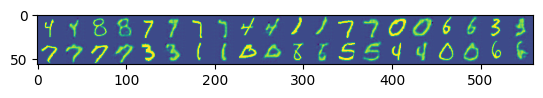

tensor([[-0.7495, -0.4095],
        [-0.7495, -0.4095],
        [-0.7495, -0.4095],
        ...,
        [-0.7495, -0.4095],
        [-0.7495, -0.4095],
        [-0.7495, -0.4095]], device='cuda:0')


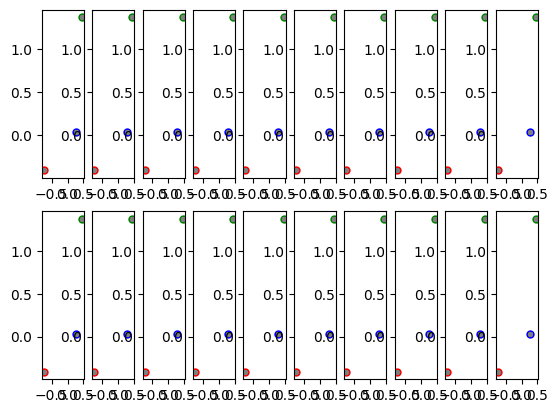

In [ ]:
model, losses, embeddings, codebook_outputs = train_vqvae()


# اعداد اصلی و بازسازی شده کنار یکدیگر پلات شده اند.

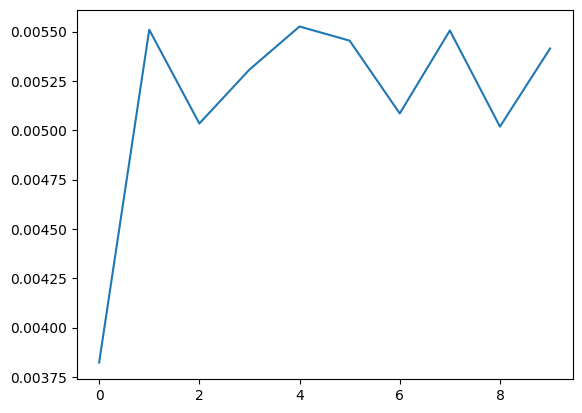

In [ ]:
losses = torch.tensor(losses).cpu()
plt.plot(losses)
# print(embeddings)
plt.show()

tensor([[-0.7495, -0.4095],
        [ 0.4486,  1.3733],
        [ 0.2754,  0.0309]], device='cuda:0')
tensor([[-0.2852, -0.2529],
        [-0.2852, -0.2529],
        [-0.2852, -0.2529],
        ...,
        [-0.2852, -0.2529],
        [-0.2852, -0.2529],
        [-0.2852, -0.2529]], device='cuda:0', grad_fn=<IndexSelectBackward0>)


<ipython-input-107-4d215bc0d0eb>:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread('tmp.png')
<ipython-input-107-4d215bc0d0eb>:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread('tmp.png')
<ipython-input-107-4d215bc0d0eb>:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread('tmp.png')
<ipython-input-107-4d215bc0d0eb>:1

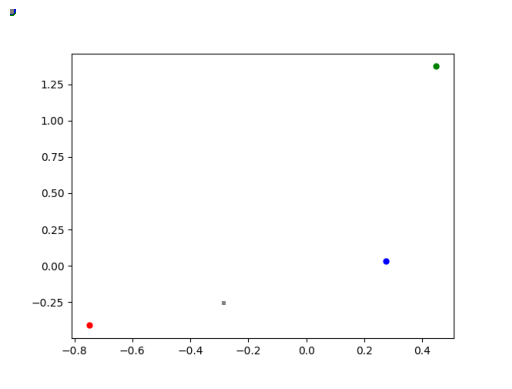

GIF created: output.gif


In [ ]:

import imageio
import glob
import os

from PIL import Image

plots = []
plots_list = []
print(embeddings[0])
print(codebook_outputs[0])
colors = ['red', 'green', 'blue']
for i in range(len(embeddings)):
  embed = embeddings[i].cpu()
  codebook = codebook_outputs[i].detach().cpu()
  plt.scatter(embed[0, 0], embed[0, 1], c=colors[0], s=25)
  plt.scatter(embed[1, 0], embed[1, 1], c=colors[1], s=25)
  plt.scatter(embed[2, 0], embed[2, 1], c=colors[2], s=25)
  plt.scatter(codebook[:, 0], codebook[:, 1], c='gray', s=5)
  plt.savefig('tmp.png')
  image = imageio.imread('tmp.png')
  plots.append(image)
  # plt.show()

plt.imshow(plots[0])
plt.axis('off')
plt.show()

# Create GIF from images
# Create GIF file path
output_gif_path = 'output.gif'
with imageio.get_writer(output_gif_path, mode='I', duration=0.5) as writer:
    for image in plots:
        writer.append_data(image)

# Check if the GIF file is created
if os.path.exists(output_gif_path):
    print(f'GIF created: {output_gif_path}')
else:
    print('Error creating the GIF.')



# colored version

In [8]:
def colorize_grayscale_batch(images):
    batch_size = images.shape[0]
    # random number for each channel
    coefficients = torch.rand((batch_size, 3, 1, 1),device=device)
    # putting the gray-scale image to each rgb channel
    colored_images = torch.cat([images] * 3, dim=1)
    # multiplying each channel by the random coeeficient
    colored_images = colored_images * coefficients
    # Clip values to be in the valid range [0, 1]
    colored_images = torch.clamp(colored_images, 0, 1)

    return colored_images


def train_vqvae_colored(num_embeddings=3,embedding_dim=2):
    transform = transforms.Compose([transforms.ToTensor()])
    mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    mnist_test = datasets.MNIST(root='./data', train=False, transform=transform)
    mnist_loader = DataLoader(mnist, batch_size=64, shuffle=True, num_workers=4)

    model = VQVAE(image_channel=3,h_dim=32,l_dim=4, num_embeddings=num_embeddings,
                  embedding_dim=embedding_dim).to(device)

    num_epochs = 10
    optimizer = Adam(model.parameters(), lr=1E-3)
    criterion = torch.nn.MSELoss()
    codebook_outputs = []
    embeddings = []
    losses = []
    for epoch_idx in range(num_epochs):
        loss = 0
        num_data=0
        for i, (im, label) in enumerate(tqdm(mnist_loader)):
            im = im.float().to(device)
            im = colorize_grayscale_batch(im)
            optimizer.zero_grad()
            out, quantize_loss, embedding, codebook = model(im)

            recon_loss = criterion(out, im)
            loss = recon_loss + quantize_loss
            loss.backward()
            optimizer.step()

            loss += loss.item()
            num_data=len(label)
            if(i%60==0):
              embeddings.append(embedding.detach())
              codebook_outputs.append(codebook)
        losses.append(loss/num_data)

        print('Finished epoch {}'.format(epoch_idx+1))
    print('Done Training...')

    # Reconstruction part

    idxs = torch.randint(0, len(mnist_test), (20, ))
    random_test_batch = []
    for idx in idxs:
      img, _ = mnist_test[idx]
      img = img.reshape(1,28,28)
      random_test_batch.append(img)
    random_test_batch = torch.stack(random_test_batch)
    random_test_batch = random_test_batch.to(device)
    model.eval()

    with torch.no_grad():
      random_test_batch = colorize_grayscale_batch(random_test_batch)
      recon, _,embedding,codebook_test = model(random_test_batch)

      out = torch.concat([random_test_batch, recon],dim=3)

      out1 = out[0]
      out2 = out[10]

      for i in range(1,10):
        out1 = torch.concat([out1, out[i]],dim=2)
        out2 = torch.concat([out2, out[10+i]],dim=2)
      img = torch.concat([out1, out2],dim=1)

      plt.imshow(img.permute(1,2,0).cpu())
      plt.show()


      # plotting the embedding of each test data
      # defining colors for each class
      colors = ['red', 'green', 'blue']
      # scatter plot with different colors
      # print(codebook_test)
      for i in range(1,20+1):
        plt.subplot(2,10,i)
        embed = embedding.cpu()
        codebook_test = codebook_test.cpu()
        plt.scatter(embed[0, 0], embed[0, 1], c=colors[0], s=25)
        plt.scatter(embed[1, 0], embed[1, 1], c=colors[1], s=25)
        plt.scatter(embed[2, 0], embed[2, 1], c=colors[2], s=25)
        plt.scatter(codebook_test[:, 0], codebook_test[:, 1], c='gray', s=5)
      plt.show()
      img = torch.concat([out1, out2],dim=1)

    return model, losses, embeddings,codebook_outputs




100%|██████████| 9912422/9912422 [00:00<00:00, 115230418.77it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 7772582.22it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34454730.86it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20159289.70it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 938/938 [00:20<00:00, 45.17it/s]


Finished epoch 1


100%|██████████| 938/938 [00:11<00:00, 78.32it/s]


Finished epoch 2


100%|██████████| 938/938 [00:11<00:00, 78.45it/s]


Finished epoch 3


100%|██████████| 938/938 [00:12<00:00, 75.13it/s]


Finished epoch 4


100%|██████████| 938/938 [00:11<00:00, 78.34it/s]


Finished epoch 5


100%|██████████| 938/938 [00:12<00:00, 72.37it/s]


Finished epoch 6


100%|██████████| 938/938 [00:12<00:00, 74.67it/s]


Finished epoch 7


100%|██████████| 938/938 [00:12<00:00, 75.52it/s]


Finished epoch 8


100%|██████████| 938/938 [00:12<00:00, 72.39it/s]


Finished epoch 9


100%|██████████| 938/938 [00:12<00:00, 77.34it/s]


Finished epoch 10


100%|██████████| 938/938 [00:12<00:00, 74.51it/s]


Finished epoch 11


100%|██████████| 938/938 [00:12<00:00, 76.57it/s]


Finished epoch 12


100%|██████████| 938/938 [00:12<00:00, 75.44it/s]


Finished epoch 13


100%|██████████| 938/938 [00:12<00:00, 75.41it/s]


Finished epoch 14


100%|██████████| 938/938 [00:12<00:00, 76.15it/s]


Finished epoch 15


100%|██████████| 938/938 [00:12<00:00, 76.71it/s]


Finished epoch 16


100%|██████████| 938/938 [00:12<00:00, 75.05it/s]


Finished epoch 17


100%|██████████| 938/938 [00:12<00:00, 74.60it/s]


Finished epoch 18


100%|██████████| 938/938 [00:12<00:00, 75.27it/s]


Finished epoch 19


100%|██████████| 938/938 [00:11<00:00, 78.50it/s]


Finished epoch 20
Done Training...


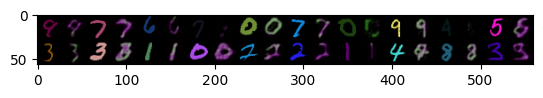

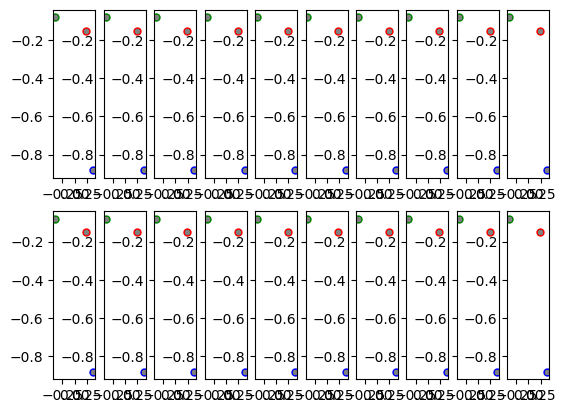

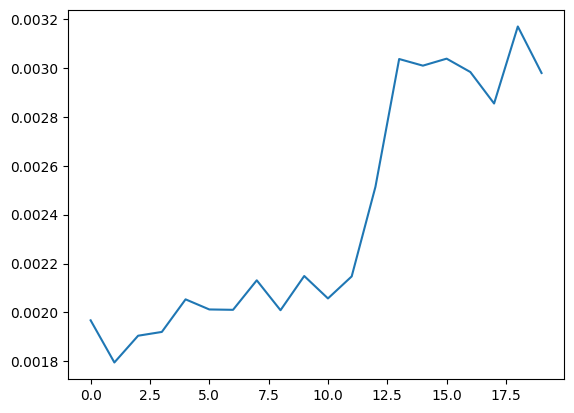

In [3]:
model, losses, embeddings, codebook_outputs = train_vqvae_colored()
losses = torch.tensor(losses).cpu()
plt.plot(losses)
# print(embeddings)
plt.show()

tensor([[ 0.2423, -0.1515],
        [-0.3983, -0.0809],
        [ 0.3916, -0.8809]], device='cuda:0')
tensor([[-0.1679, -0.0205],
        [-0.1679, -0.0205],
        [-0.1679, -0.0205],
        ...,
        [-0.1679, -0.0205],
        [-0.1679, -0.0205],
        [-0.1679, -0.0205]], device='cuda:0', grad_fn=<IndexSelectBackward0>)


  0%|          | 0/320 [00:00<?, ?it/s]<ipython-input-7-6c7d2a49fe23>:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread('tmp.png')
100%|██████████| 320/320 [26:18<00:00,  4.93s/it]


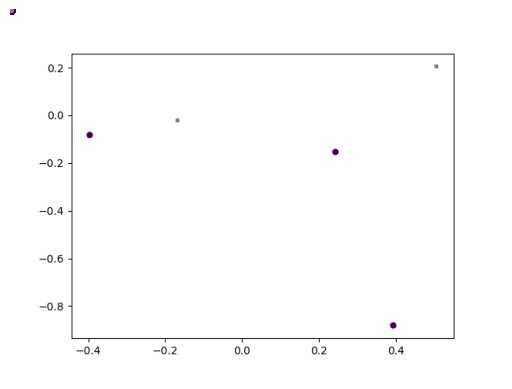

GIF created: output_colored.gif


In [7]:
plots = []
plots_list = []
print(embeddings[0])
print(codebook_outputs[0])
np.random.seed(42)
x = np.random.rand(50)
y = np.random.rand(50)
colors = np.arange(50)
for i in tqdm(range(len(embeddings))):
  embed = embeddings[i].cpu()
  codebook = codebook_outputs[i].detach().cpu()
  plt.scatter(embed[0, 0], embed[0, 1], c=colors[0], s=25)
  plt.scatter(embed[1, 0], embed[1, 1], c=colors[1], s=25)
  plt.scatter(embed[2, 0], embed[2, 1], c=colors[2], s=25)
  plt.scatter(codebook[:, 0], codebook[:, 1], c='gray', s=5)
  plt.savefig('tmp.png')
  image = imageio.imread('tmp.png')
  plots.append(image)
  # plt.show()

plt.imshow(plots[0])
plt.axis('off')
plt.show()

# Create GIF from images
# Create GIF file path
output_gif_path = 'output_colored.gif'
with imageio.get_writer(output_gif_path, mode='I', duration=0.5) as writer:
    for image in plots:
        writer.append_data(image)

# Check if the GIF file is created
if os.path.exists(output_gif_path):
    print(f'GIF created: {output_gif_path}')
else:
    print('Error creating the GIF.')

#higher number of embeddings

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 938/938 [00:13<00:00, 69.85it/s]


Finished epoch 1


100%|██████████| 938/938 [00:12<00:00, 76.69it/s]


Finished epoch 2


100%|██████████| 938/938 [00:15<00:00, 60.59it/s]


Finished epoch 3


100%|██████████| 938/938 [00:15<00:00, 60.92it/s]


Finished epoch 4


100%|██████████| 938/938 [00:13<00:00, 67.53it/s]


Finished epoch 5


100%|██████████| 938/938 [00:12<00:00, 75.11it/s]


Finished epoch 6


100%|██████████| 938/938 [00:12<00:00, 74.01it/s]


Finished epoch 7


100%|██████████| 938/938 [00:12<00:00, 74.87it/s]


Finished epoch 8


100%|██████████| 938/938 [00:12<00:00, 75.93it/s]


Finished epoch 9


100%|██████████| 938/938 [00:12<00:00, 77.83it/s]


Finished epoch 10
Done Training...


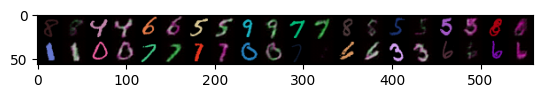

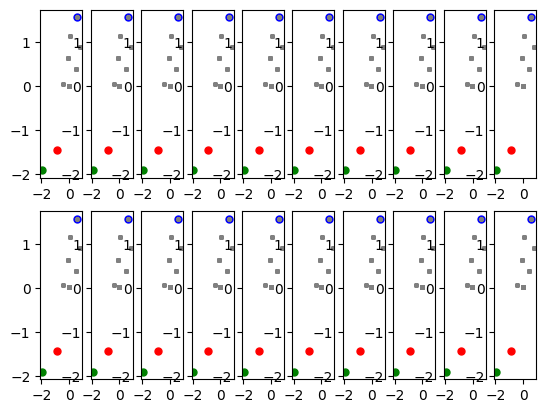

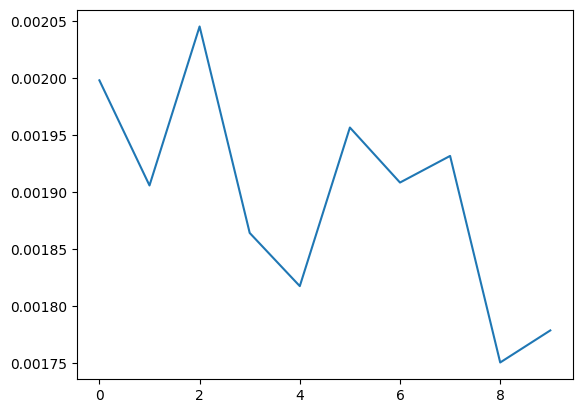

In [9]:
model, losses, embeddings, codebook_outputs = train_vqvae_colored(num_embeddings=10,embedding_dim=2)
losses = torch.tensor(losses).cpu()
plt.plot(losses)
# print(embeddings)
plt.show()

100%|██████████| 938/938 [00:13<00:00, 71.84it/s]


Finished epoch 1


100%|██████████| 938/938 [00:12<00:00, 74.47it/s]


Finished epoch 2


100%|██████████| 938/938 [00:12<00:00, 77.30it/s]


Finished epoch 3


100%|██████████| 938/938 [00:12<00:00, 76.80it/s]


Finished epoch 4


100%|██████████| 938/938 [00:12<00:00, 76.81it/s]


Finished epoch 5


100%|██████████| 938/938 [00:12<00:00, 74.31it/s]


Finished epoch 6


100%|██████████| 938/938 [00:12<00:00, 74.45it/s]


Finished epoch 7


100%|██████████| 938/938 [00:12<00:00, 74.40it/s]


Finished epoch 8


100%|██████████| 938/938 [00:12<00:00, 74.22it/s]


Finished epoch 9


100%|██████████| 938/938 [00:13<00:00, 71.16it/s]


Finished epoch 10
Done Training...


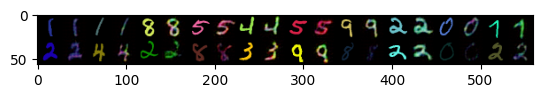

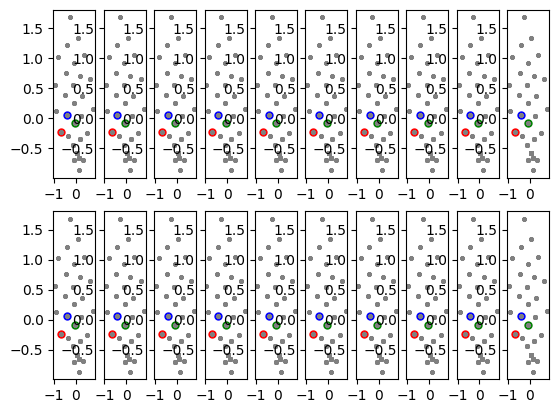

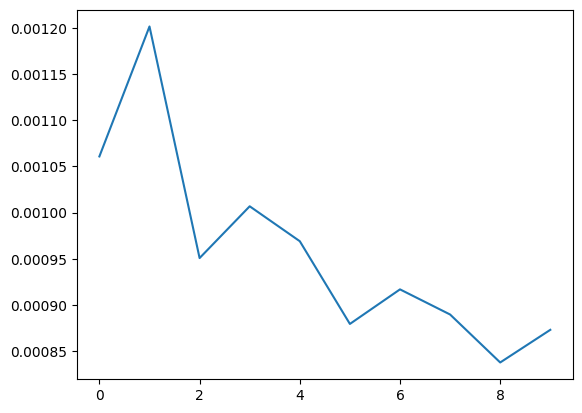

In [10]:
model, losses, embeddings, codebook_outputs = train_vqvae_colored(num_embeddings=30,embedding_dim=2)
losses = torch.tensor(losses).cpu()
plt.plot(losses)
# print(embeddings)
plt.show()

100%|██████████| 938/938 [00:12<00:00, 73.36it/s]


Finished epoch 1


100%|██████████| 938/938 [00:12<00:00, 73.66it/s]


Finished epoch 2


100%|██████████| 938/938 [00:12<00:00, 73.03it/s]


Finished epoch 3


100%|██████████| 938/938 [00:12<00:00, 73.76it/s]


Finished epoch 4


100%|██████████| 938/938 [00:13<00:00, 72.07it/s]


Finished epoch 5


100%|██████████| 938/938 [00:12<00:00, 73.90it/s]


Finished epoch 6


100%|██████████| 938/938 [00:12<00:00, 75.07it/s]


Finished epoch 7


100%|██████████| 938/938 [00:12<00:00, 74.69it/s]


Finished epoch 8


100%|██████████| 938/938 [00:12<00:00, 74.82it/s]


Finished epoch 9


100%|██████████| 938/938 [00:12<00:00, 72.32it/s]


Finished epoch 10
Done Training...


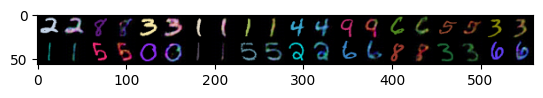

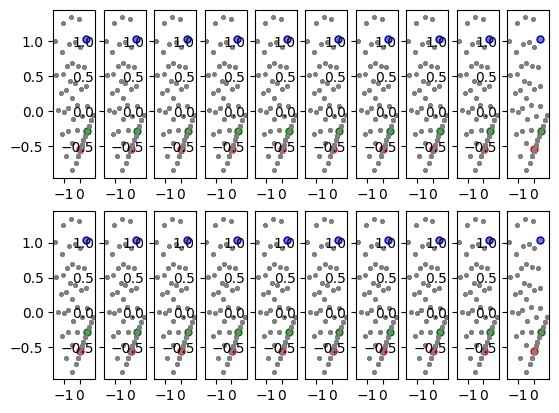

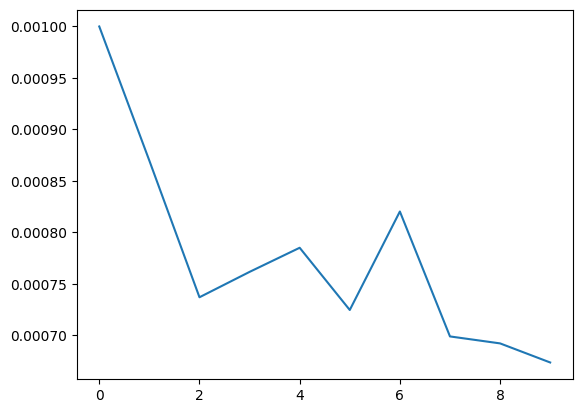

In [11]:
model, losses, embeddings, codebook_outputs = train_vqvae_colored(num_embeddings=50,embedding_dim=2)
losses = torch.tensor(losses).cpu()
plt.plot(losses)
# print(embeddings)
plt.show()

# higher number of embedding dimension

In [13]:
def train_vqvae_colored_high_dim(num_embeddings=3,embedding_dim=2):
    transform = transforms.Compose([transforms.ToTensor()])
    mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    mnist_test = datasets.MNIST(root='./data', train=False, transform=transform)
    mnist_loader = DataLoader(mnist, batch_size=64, shuffle=True, num_workers=4)

    model = VQVAE(image_channel=3,h_dim=32,l_dim=4, num_embeddings=num_embeddings,
                  embedding_dim=embedding_dim).to(device)

    num_epochs = 10
    optimizer = Adam(model.parameters(), lr=1E-3)
    criterion = torch.nn.MSELoss()
    codebook_outputs = []
    embeddings = []
    losses = []
    for epoch_idx in range(num_epochs):
        loss = 0
        num_data=0
        for i, (im, label) in enumerate(tqdm(mnist_loader)):
            im = im.float().to(device)
            im = colorize_grayscale_batch(im)
            optimizer.zero_grad()
            out, quantize_loss, embedding, codebook = model(im)

            recon_loss = criterion(out, im)
            loss = recon_loss + quantize_loss
            loss.backward()
            optimizer.step()

            loss += loss.item()
            num_data=len(label)
            if(i%60==0):
              embeddings.append(embedding.detach())
              codebook_outputs.append(codebook)
        losses.append(loss/num_data)

        print('Finished epoch {}'.format(epoch_idx+1))
    print('Done Training...')

    # Reconstruction part

    idxs = torch.randint(0, len(mnist_test), (20, ))
    random_test_batch = []
    for idx in idxs:
      img, _ = mnist_test[idx]
      img = img.reshape(1,28,28)
      random_test_batch.append(img)
    random_test_batch = torch.stack(random_test_batch)
    random_test_batch = random_test_batch.to(device)
    model.eval()

    with torch.no_grad():
      random_test_batch = colorize_grayscale_batch(random_test_batch)
      recon, _,embedding,codebook_test = model(random_test_batch)

      out = torch.concat([random_test_batch, recon],dim=3)

      out1 = out[0]
      out2 = out[10]

      for i in range(1,10):
        out1 = torch.concat([out1, out[i]],dim=2)
        out2 = torch.concat([out2, out[10+i]],dim=2)
      img = torch.concat([out1, out2],dim=1)

      plt.imshow(img.permute(1,2,0).cpu())
      plt.show()


      # plotting the embedding of each test data
      # defining colors for each class
      colors = ['red', 'green', 'blue']
      # scatter plot with different colors
      # print(codebook_test)
      img = torch.concat([out1, out2],dim=1)

    return model, losses, embeddings,codebook_outputs


100%|██████████| 938/938 [00:15<00:00, 62.25it/s]


Finished epoch 1


100%|██████████| 938/938 [00:12<00:00, 72.93it/s]


Finished epoch 2


100%|██████████| 938/938 [00:12<00:00, 73.44it/s]


Finished epoch 3


100%|██████████| 938/938 [00:12<00:00, 73.18it/s]


Finished epoch 4


100%|██████████| 938/938 [00:12<00:00, 72.63it/s]


Finished epoch 5


100%|██████████| 938/938 [00:12<00:00, 72.80it/s]


Finished epoch 6


100%|██████████| 938/938 [00:12<00:00, 73.11it/s]


Finished epoch 7


100%|██████████| 938/938 [00:13<00:00, 67.60it/s]


Finished epoch 8


100%|██████████| 938/938 [00:12<00:00, 74.49it/s]


Finished epoch 9


100%|██████████| 938/938 [00:12<00:00, 74.56it/s]


Finished epoch 10
Done Training...


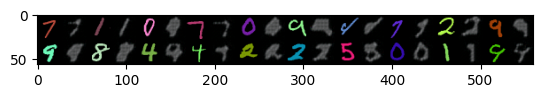

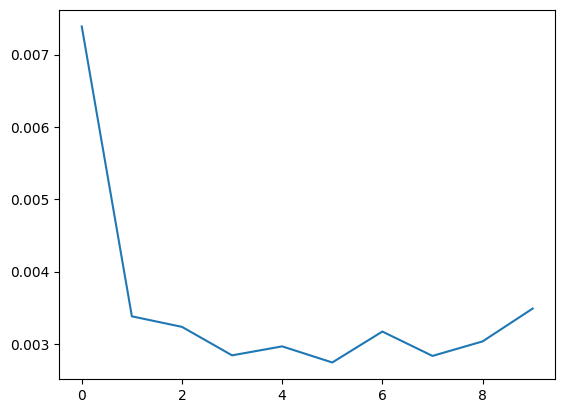

In [16]:
model, losses, embeddings, codebook_outputs = train_vqvae_colored_high_dim(num_embeddings=3,embedding_dim=15)
losses = torch.tensor(losses).cpu()
plt.plot(losses)
# print(embeddings)
plt.show()

100%|██████████| 938/938 [00:14<00:00, 65.96it/s]


Finished epoch 1


100%|██████████| 938/938 [00:12<00:00, 72.82it/s]


Finished epoch 2


100%|██████████| 938/938 [00:12<00:00, 73.55it/s]


Finished epoch 3


100%|██████████| 938/938 [00:12<00:00, 73.61it/s]


Finished epoch 4


100%|██████████| 938/938 [00:12<00:00, 72.81it/s]


Finished epoch 5


100%|██████████| 938/938 [00:12<00:00, 73.22it/s]


Finished epoch 6


100%|██████████| 938/938 [00:12<00:00, 73.50it/s]


Finished epoch 7


100%|██████████| 938/938 [00:12<00:00, 73.71it/s]


Finished epoch 8


100%|██████████| 938/938 [00:12<00:00, 73.29it/s]


Finished epoch 9


100%|██████████| 938/938 [00:12<00:00, 73.60it/s]


Finished epoch 10
Done Training...


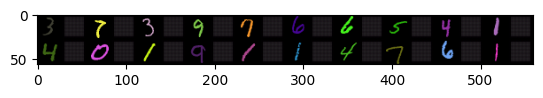

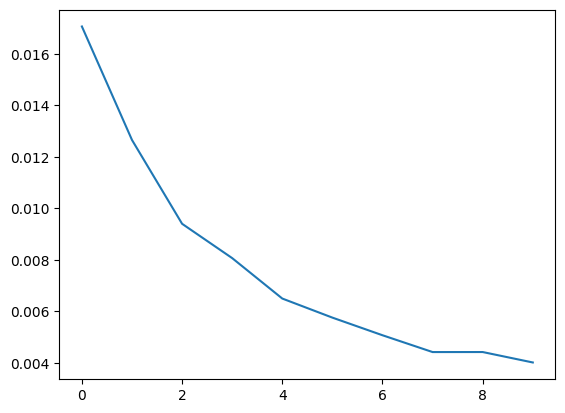

In [15]:
model, losses, embeddings, codebook_outputs = train_vqvae_colored_high_dim(num_embeddings=3,embedding_dim=50)
losses = torch.tensor(losses).cpu()
plt.plot(losses)
# print(embeddings)
plt.show()

همان طور که مشاهده می کنیم با بالا بردن ابعاد امبدینگ نتیجه ی لاس بهتر می شود و نتیجه ی بازسازی هم بهتر می شود ولی با بالا بردن تعداد امبدینگ ها نتیجه ی باز سازی خراب می شودو لاس هم افزایش می یابد..